# Automatic Differentiation

In machine learning, we *train* models, updating them successively so that they get better and better as they see more and more data. Usually, *getting better* means minimizing a *loss function*, a score that answers the question "how *bad* is our model?" With neural networks, we typically choose loss functions that are differentiable with respect to our parameters.
Put simply, this means that for each of the model's parameters, we can determine how much *increasing* or *decreasing* it might affect the loss. While the calculations for taking these derivatives are straightforward, requiring only some basic calculus, for complex models, working out the updates by hand can be a pain (and often error-prone).

The autograd package expedites this work by automatically calculating derivatives. And while many other libraries require that we compile a symbolic graph to take automatic derivatives, `autograd` allows us to take derivatives while writing  ordinary imperative code. Every time we pass data through our model, `autograd` builds a graph on the fly, tracking which data combined through which operations to produce the output. This graph enables `autograd` to subsequently backpropagate gradients on command. Here *backpropagate* simply means to trace through the compute graph, filling in the partial derivatives with respect to each parameter.

In [1]:
import torch
from torch.autograd import Variable

## A Simple Example

As a toy example, say that we are interested in differentiating the mapping $y = 2\mathbf{x}^{\top}\mathbf{x}$ with respect to the column vector $\mathbf{x}$. To start, let's create the variable `x` and assign it an initial value.

In [2]:
x = Variable(torch.arange(4, dtype=torch.float32).reshape((4, 1)), requires_grad=True)
print(x)

tensor([[0.],
        [1.],
        [2.],
        [3.]], requires_grad=True)


Once we compute the gradient of ``y`` with respect to ``x``, we will need a place to store it. We can tell a tensor that we plan to store a gradient by the ``requires_grad=True`` keyword.

Now we are going to compute ``y`` and PyTorch will generate a computation graph on the fly. Autograd is reverse automatic differentiation system. Conceptually, autograd records a graph recording all of the operations that created the data as you execute operations, giving you a directed acyclic graph whose leaves are the input tensors and roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule.

Note that building the computation graph requires a nontrivial amount of computation. So PyTorch will *only* build the graph when explicitly told to do so. For a tensor to be “recordable”, it must be wrapped with torch.autograd.Variable. The Variable class provides almost the same API as Tensor, but augments it with the ability to interplay with torch.autograd.Function in order to be differentiated automatically. More precisely, a Variable records the history of operations on a Tensor.

In [3]:
y = 2*torch.mm(x.t(),x)
print(y)

tensor([[28.]], grad_fn=<MulBackward0>)


Since the shape of `x` is (4, 1), `y` is a scalar. Next, we can automatically find the gradient by calling the `backward` function. It should be noted that if `y` is not a scalar, PyTorch will first sum the elements in `y` to get the new variable by default, and then find the gradient of the variable with respect to `x`.

In [4]:
y.backward()

Since every Variable except for inputs is the result of an operation, each Variable has an associated grad_fn, which is the torch.autograd.Function that is used to compute the backward step. For inputs it is None:

In [5]:
print("x.grad:", x.grad)
print("x.grad_fn:", x.grad_fn)
print("y.grad_fn:", y.grad_fn)

x.grad: tensor([[ 0.],
        [ 4.],
        [ 8.],
        [12.]])
x.grad_fn: None
y.grad_fn: <MulBackward0 object at 0x7fa468940c90>


The gradient of the function $y = 2\mathbf{x}^{\top}\mathbf{x}$ with respect to $\mathbf{x}$ should be $4\mathbf{x}$. Now let's verify that the gradient produced is correct.

In [6]:
print((x.grad - 4*x).norm().item() == 0)
print(x.grad)

True
tensor([[ 0.],
        [ 4.],
        [ 8.],
        [12.]])


## Training Mode and Evaluation Mode

`Model` will change the running mode to the evaluation mode on calling `model.eval()` or to the training mode on calling `model.train()`.

In some cases, the same model behaves differently in the training and prediction modes (e.g. when using neural techniques such as dropout and batch normalization). In other cases, some models may store more auxiliary variables to make computing gradients easier. We will cover these differences in detail in later chapters. For now, you do not need to worry about them.

## Computing the Gradient of Python Control Flow

One benefit of using automatic differentiation is that even if the computational graph of the function contains Python's control flow (such as conditional and loop control), we may still be able to find the gradient of a variable. Consider the following program:  It should be emphasized that the number of iterations of the loop (while loop) and the execution of the conditional judgment (if statement) depend on the value of the input `b`.

In [7]:
def f(a):
    b = a * 2
    while b.norm().item() < 1000:
        b = b * 2
    if b.sum().item() > 0:
        c = b
    else:
        c = 100 * b
    return c

Note that the number of iterations of the while loop and the execution of the conditional statement (if then else) depend on the value of `a`. To compute gradients, we need to `record` the calculation, and then call the `backward` function to calculate the gradient.

In [8]:
a = torch.randn(size=(1,))
a.requires_grad=True
d = f(a)
d.backward()

Let's analyze the `f` function defined above. As you can see, it is piecewise linear in its input `a`. In other words, for any `a` there exists some constant such that for a given range `f(a) = g * a`. Consequently `d / a` allows us to verify that the gradient is correct:

In [9]:
print(a.grad == (d / a))

tensor([True])


## Head gradients and the chain rule

*Caution: This part is tricky and not necessary to understanding subsequent sections. That said, it is needed if you want to build new layers from scratch. You can skip this on a first read.*

Sometimes when we call the backward method, e.g. `y.backward()`, where
`y` is a function of `x` we are just interested in the derivative of
`y` with respect to `x`. Mathematicians write this as
$\frac{dy(x)}{dx}$. At other times, we may be interested in the
gradient of `z` with respect to `x`, where `z` is a function of `y`,
which in turn, is a function of `x`. That is, we are interested in
$\frac{d}{dx} z(y(x))$. Recall that by the chain rule

$$\frac{d}{dx} z(y(x)) = \frac{dz(y)}{dy} \frac{dy(x)}{dx}.$$

So, when ``y`` is part of a larger function ``z`` and we want ``x.grad`` to store $\frac{dz}{dx}$, we can pass in the *head gradient* $\frac{dz}{dy}$ as an input to ``backward()``. The default argument is ``torch.ones_like(y)``. See [Wikipedia](https://en.wikipedia.org/wiki/Chain_rule) for more details.

In [10]:
x = Variable(torch.tensor([[0.],[1.],[2.],[3.]]), requires_grad=True)
y = x * 2
z = y * x

head_gradient = torch.tensor([[10], [1.], [.1], [.01]])
z.backward(head_gradient)
print(x.grad)

tensor([[0.0000],
        [4.0000],
        [0.8000],
        [0.1200]])


## Summary

* PyTorch provides an `autograd` package to automate the derivation process.
* PyTorch's `autograd` package can be used to derive general imperative programs.
* The running modes of PyTorch include the training mode and the evaluation mode.

## Exercises

1. In the control flow example where we calculate the derivative of `d` with respect to `a`, what would happen if we changed the variable `a` to a random vector or matrix. At this point, the result of the calculation `f(a)` is no longer a scalar. What happens to the result? How do we analyze this?
- They result would be vector or matrix. We can analyze it by externally compute gradient.

2. Redesign an example of finding the gradient of the control flow. Run and analyze the result.
- Check the code below

3. In a second-price auction (such as in eBay or in computational advertising), the winning bidder pays the second-highest price. Compute the gradient of the final price with respect to the winning bidder's bid using `autograd`. What does the result tell you about the mechanism? If you are curious to learn more about second-price auctions, check out this paper by [Edelman, Ostrovski and Schwartz, 2005](https://www.benedelman.org/publications/gsp-060801.pdf).
-

4. Why is the second derivative much more expensive to compute than the first derivative?
- Because of the chain rule, we need to compute $N^2$ elements while we need to compute $N$ elements in the first derivative.

5. Derive the head gradient relationship for the chain rule. If you get stuck, use the ["Chain rule" article on Wikipedia](https://en.wikipedia.org/wiki/Chain_rule).
- $\text{head gradient} = \frac{dz}{dy} = \frac{dz}{dx}\frac{dx}{dy}$

6. Assume $f(x) = \sin(x)$. Plot $f(x)$ and $\frac{df(x)}{dx}$ on a graph, where you computed the latter without any symbolic calculations, i.e. without exploiting that $f'(x) = \cos(x)$.
- Check the code below


In [11]:
def f0(a):
    b = a * a + a
    if b.sum().item() > 0:
        c = b
    else:
        c = 100 * b
    return c


$d = 2a^2 + a\\\text{a.grad} = 2a + 1$

In [12]:
a = torch.randn(size=(1,))
a.requires_grad=True
d = f0(a)
d.backward()
print(a)
print(d)
print(a.grad)

tensor([0.3273], requires_grad=True)
tensor([0.4344], grad_fn=<AddBackward0>)
tensor([1.6546])


(-3.4557519189487724,
 3.4557519189487724,
 -1.0999999381914298,
 1.0999987020200273)

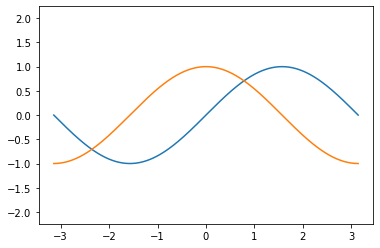

In [13]:
import numpy as np
from matplotlib import pyplot as plt 

x = np.linspace(-np.pi, np.pi, 1000)
X = torch.tensor(x, requires_grad=True)
y = torch.sin(X).sum().backward()

plt.plot(X.detach().numpy(), np.sin(x))
plt.plot(X.detach().numpy(), X.grad)
plt.axis('equal')
